/tmp/ipykernel_30/584754165.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Dataset Analysis and Visualizations:
Total number of matches: 1024
Total number of players: 706
Seasons covered: 2008 to 2023


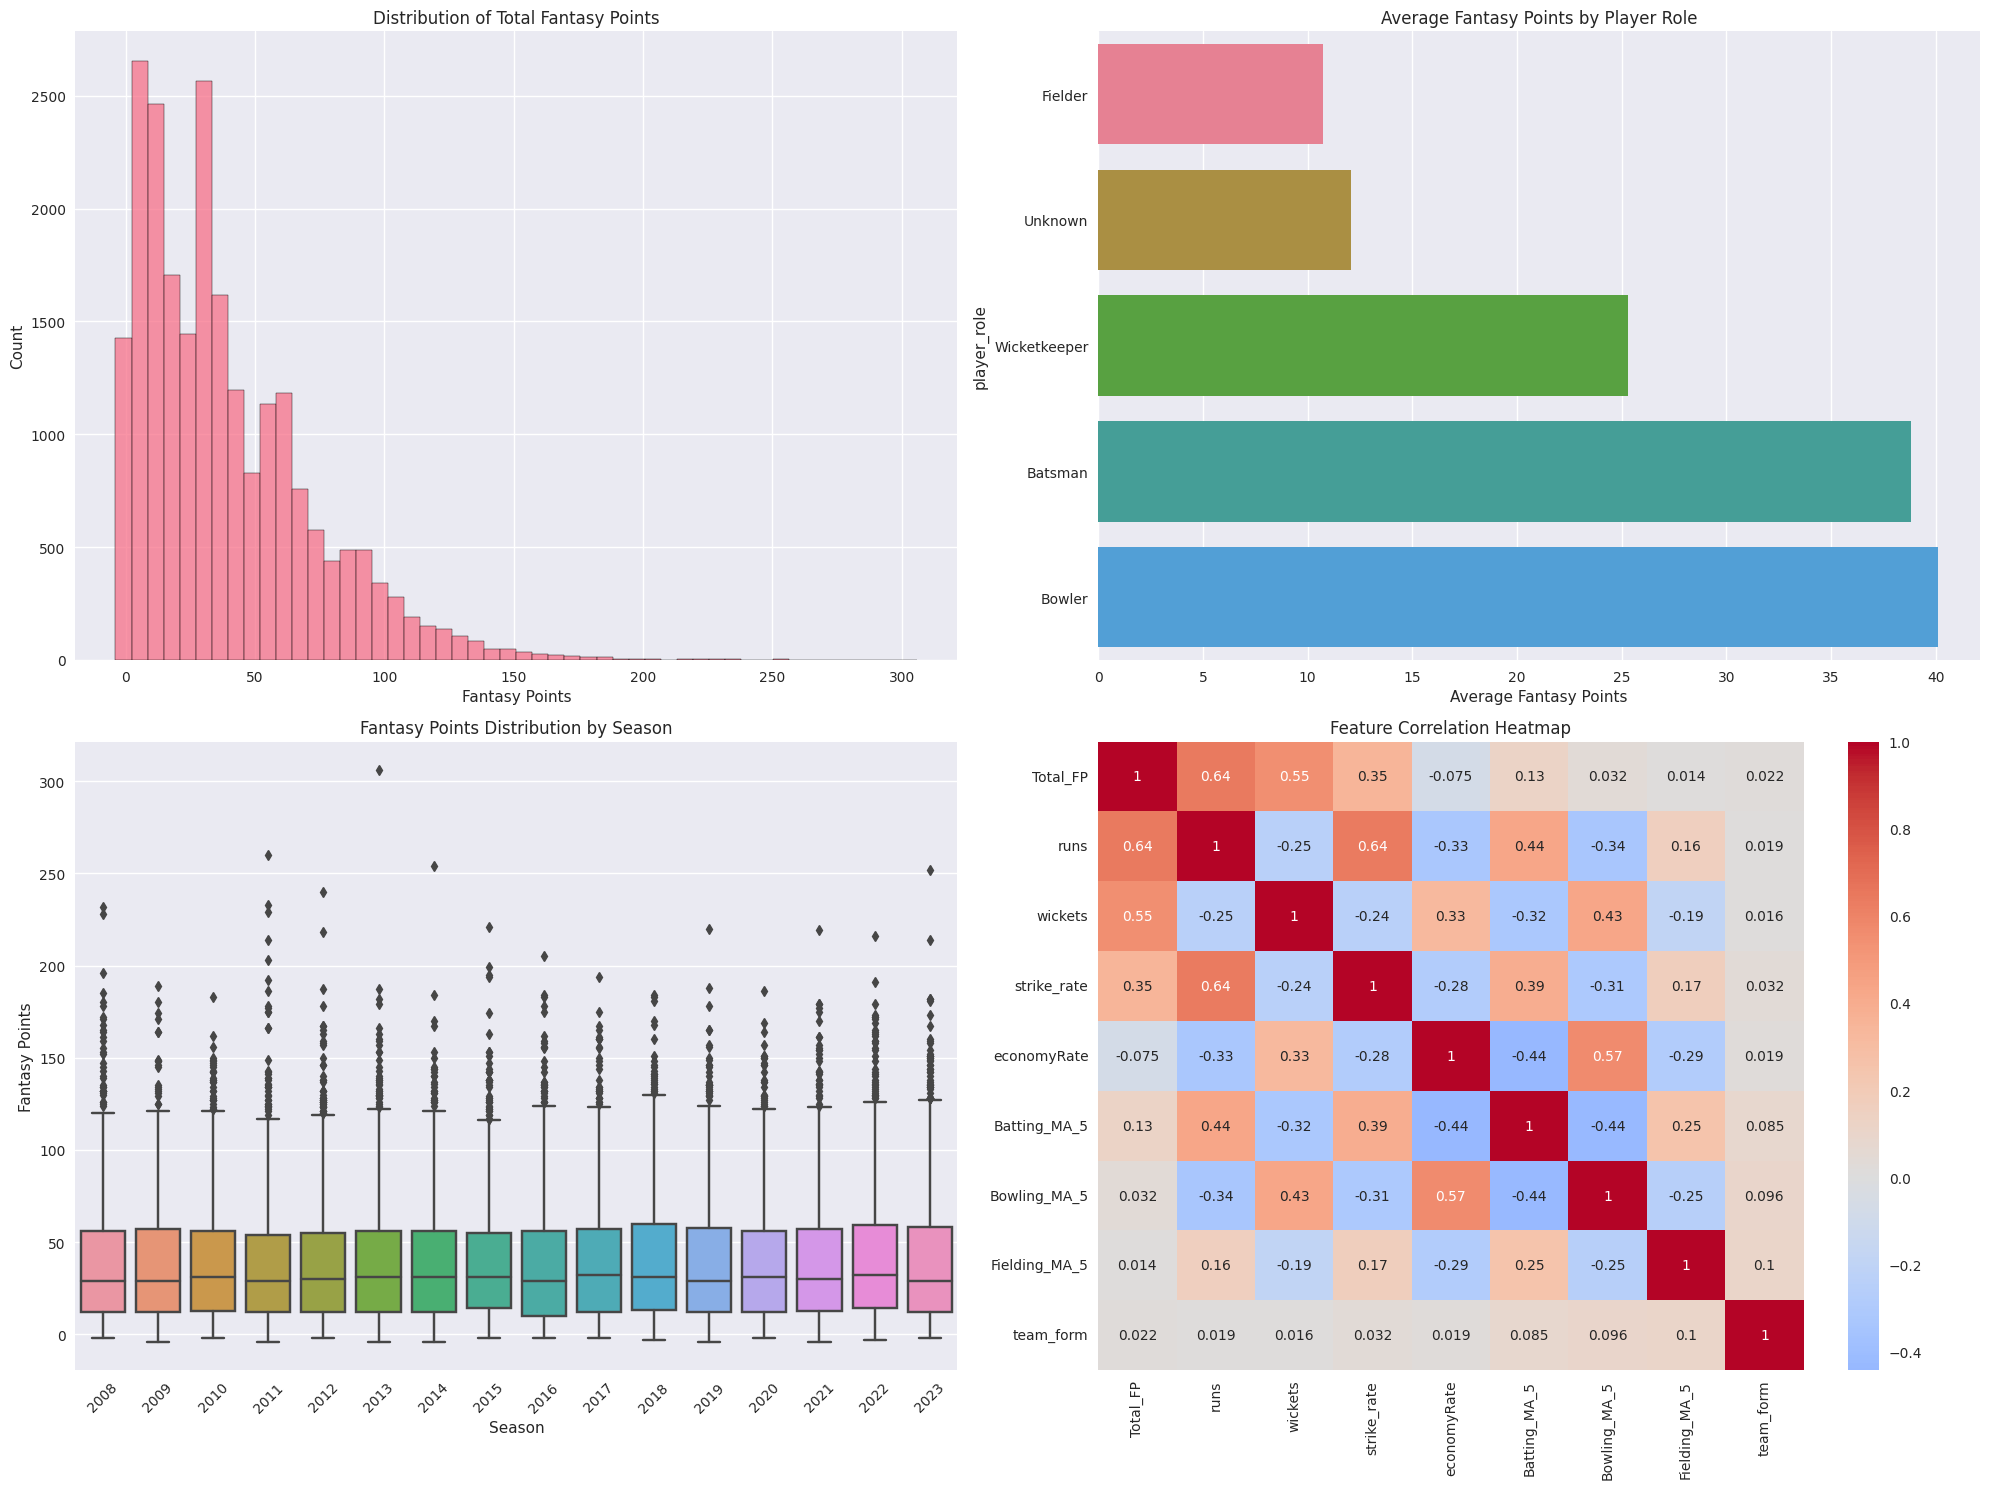

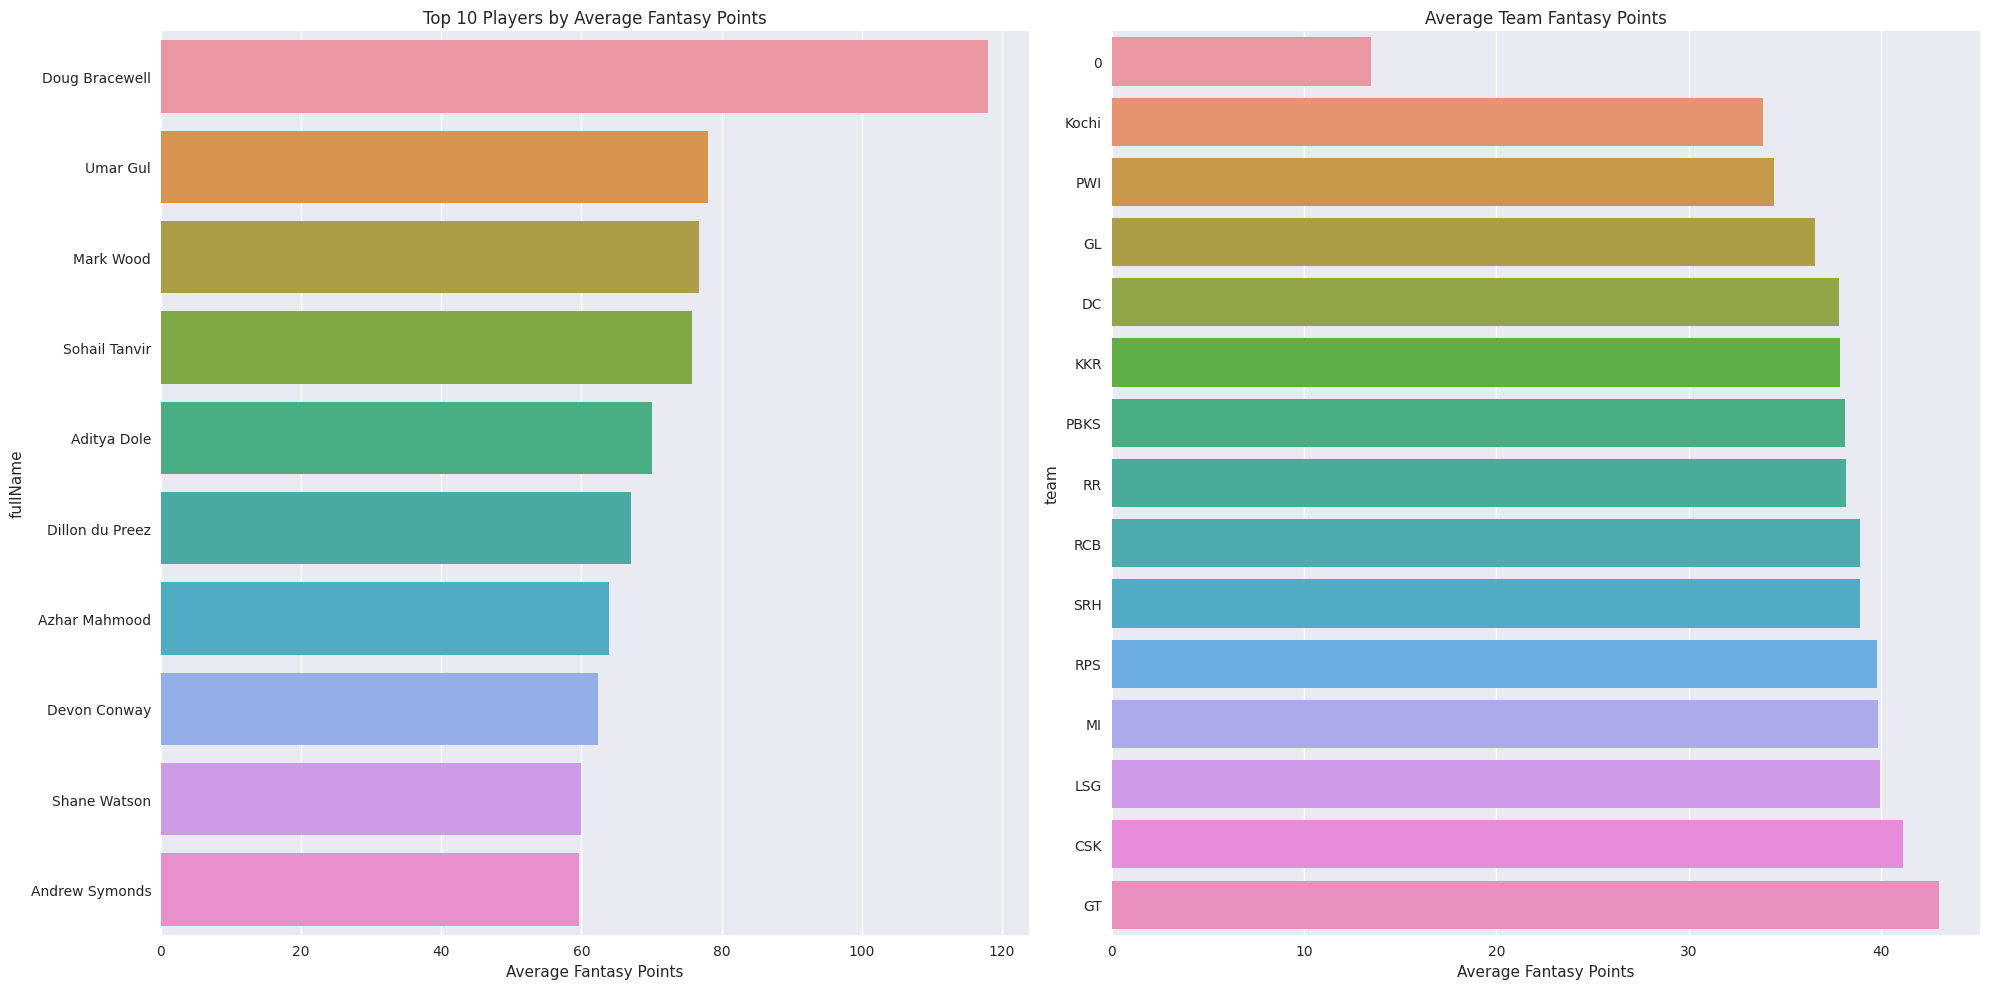


Predicting match 1/74 (ID: 1359475)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Match 1 Metrics:
- Binary Cross-Entropy Loss: 0.1805
- Accuracy: 0.8696
- ROC-AUC Score: 0.9848

Predicting match 2/74 (ID: 1359476)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Match 2 Metrics:
- Binary Cross-Entropy Loss: 0.1200
- Accuracy: 1.0000
- ROC-AUC Score: 1.0000

Predicting match 3/74 (ID: 1359477)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Match 3 Metrics:
- Binary Cross-Entropy Loss: 0.2293
- Accuracy: 0.9615
- ROC-AUC Score: 0.9524

Predicting match 4/74 (ID: 1359478)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Match 4 Metrics:
- Binary Cross-Entropy Loss: 0.0546
- Accuracy: 1.0000
- ROC-AUC Score: 1.0000

Predicting match 5/74 (ID: 1359479)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Match 5 Metrics:
- Binary Cross-Entropy Loss: 0.1365
- Accuracy: 0.9565
- ROC-AUC Score: 0.9921

Predicting match 6/74 (ID: 1359480)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Match 6 Metrics:
- Binary Cross-Entropy Loss: 

KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Load the data
data = pd.read_csv('/kaggle/input/dataset-cricket/3.csv')

def clean_numeric_columns(df, columns):
    """
    Clean and convert columns to numeric type
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def create_advanced_features(df):
    """
    Create advanced features for the model
    """
    # Clean numeric columns first
    numeric_columns = [
        'runs', 'balls', 'wickets', 'Overs_Bowled', 
        'strike_rate', 'economyRate', 
        'mean_last_5_runs', 'mean_last_5_wickets'
    ]
    df = clean_numeric_columns(df, numeric_columns)
    
    # Replace NaN with 0 or median as appropriate
    df['runs'] = df['runs'].fillna(0)
    df['balls'] = df['balls'].fillna(0)
    df['wickets'] = df['wickets'].fillna(0)
    df['Overs_Bowled'] = df['Overs_Bowled'].fillna(0)
    
    # Prevent division by zero
    df['runs_per_ball'] = np.where(df['balls'] != 0, df['runs'] / df['balls'], 0)
    df['wicket_rate'] = np.where(df['Overs_Bowled'] != 0, df['wickets'] / df['Overs_Bowled'], 0)
    
    # Additional feature engineering with safety checks
    df['batting_impact'] = df['runs'] * df['strike_rate'] / 100
    df['bowling_impact'] = np.where(df['economyRate'] != 0, 
                                    df['wickets'] * (1 / df['economyRate']), 
                                    0)
    
    # Combine multiple performance indicators
    df['overall_performance'] = (
        df['mean_last_5_runs'].fillna(0) * 0.3 + 
        df['mean_last_5_wickets'].fillna(0) * 0.3 + 
        df['Batting_FP_x'].fillna(0) * 0.2 + 
        df['Bowling_FP_x'].fillna(0) * 0.2
    )
    
    return df

def analyze_and_visualize_dataset(data):
    """
    Create and display various visualizations for dataset analysis
    """
    print("\nDataset Analysis and Visualizations:")
    print(f"Total number of matches: {data['match_id'].nunique()}")
    print(f"Total number of players: {data['fullName'].nunique()}")
    print(f"Seasons covered: {data['season'].min()} to {data['season'].max()}")
    
    # Create figure with subplots
    plt.figure(figsize=(20, 15))
    
    # 1. Distribution of Total Fantasy Points
    plt.subplot(2, 2, 1)
    sns.histplot(data=data, x='Total_FP', bins=50)
    plt.title('Distribution of Total Fantasy Points')
    plt.xlabel('Fantasy Points')
    plt.ylabel('Count')
    
    # 2. Average Fantasy Points by Player Role
    plt.subplot(2, 2, 2)
    role_avg = data.groupby('player_role')['Total_FP'].mean().sort_values(ascending=True)
    sns.barplot(x=role_avg.values, y=role_avg.index)
    plt.title('Average Fantasy Points by Player Role')
    plt.xlabel('Average Fantasy Points')
    
    # 3. Fantasy Points Distribution by Season
    plt.subplot(2, 2, 3)
    sns.boxplot(data=data, x='season', y='Total_FP')
    plt.title('Fantasy Points Distribution by Season')
    plt.xticks(rotation=45)
    plt.xlabel('Season')
    plt.ylabel('Fantasy Points')
    
    # 4. Correlation Heatmap
    plt.subplot(2, 2, 4)
    features_to_correlate = [
        'Total_FP', 'runs', 'wickets', 'strike_rate', 'economyRate',
        'Batting_MA_5', 'Bowling_MA_5', 'Fielding_MA_5', 'team_form'
    ]
    correlation_matrix = data[features_to_correlate].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plots
    plt.figure(figsize=(20, 10))
    
    # 5. Top 10 Performers
    plt.subplot(1, 2, 1)
    top_performers = data.groupby('fullName')['Total_FP'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=top_performers.values, y=top_performers.index)
    plt.title('Top 10 Players by Average Fantasy Points')
    plt.xlabel('Average Fantasy Points')
    
    # 6. Team Performance
    plt.subplot(1, 2, 2)
    team_performance = data.groupby('team')['Total_FP'].mean().sort_values(ascending=True)
    sns.barplot(x=team_performance.values, y=team_performance.index)
    plt.title('Average Team Fantasy Points')
    plt.xlabel('Average Fantasy Points')
    
    plt.tight_layout()
    plt.show()

def create_model(input_shape):
    """
    Create and return the neural network model
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_and_predict_match(train_data, test_match, features):
    """
    Train model on historical data and predict for a single match
    """
    # Prepare training data
    X_train = train_data[features]
    y_train = train_data['Total_FP']
    X_test = test_match[features]
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to binary classification
    median_fp = y_train.median()
    y_train_binary = (y_train > median_fp).astype(int)
    
    # Create and compile model
    model = create_model(X_train_scaled.shape[1:])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        0.001, decay_steps=100, decay_rate=0.9, staircase=True
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    
    # Train model
    model.fit(
        X_train_scaled, y_train_binary,
        epochs=100,
        validation_split=0.2,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Predict
    return model.predict(X_test_scaled).flatten()

def create_performance_visualizations(match_losses, match_accuracies, match_auc_scores):
    """
    Create visualizations for model performance metrics
    """
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(match_losses, marker='o')
    plt.title('Binary Cross-Entropy Loss by Match')
    plt.xlabel('Match Number')
    plt.ylabel('Loss')
    
    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(match_accuracies, marker='o', color='green')
    plt.title('Accuracy by Match')
    plt.xlabel('Match Number')
    plt.ylabel('Accuracy')
    
    # Plot AUC scores
    plt.subplot(1, 3, 3)
    plt.plot(match_auc_scores, marker='o', color='orange')
    plt.title('ROC-AUC Score by Match')
    plt.xlabel('Match Number')
    plt.ylabel('ROC-AUC')
    
    plt.tight_layout()
    plt.show()

def rolling_window_prediction(data):
    """
    Implement rolling window prediction for 2023 matches with enhanced metrics and visualizations
    """
    # First, analyze and visualize the dataset
    analyze_and_visualize_dataset(data)
    
    # Define features
    features = [
        'batting_position', 'runs', 'strike_rate', 
        'mean_last_5_runs', 'mean_last_5_wickets', 
        'overall_economy_rate', 'runs_per_ball', 
        'wicket_rate', 'batting_impact', 
        'bowling_impact', 'overall_performance',
        'Batting_MA_5', 'Bowling_MA_5', 'Fielding_MA_5',
        'team_form'
    ]
    
    # Preprocess the data
    data = create_advanced_features(data)
    
    # Split into historical (2008-2022) and 2023 data
    historical_data = data[data['season'] <= 2022].copy()
    data_2023 = data[data['season'] == 2023].copy()
    
    # Sort 2023 matches by match_id
    data_2023 = data_2023.sort_values('match_id')
    unique_matches = data_2023['match_id'].unique()
    
    # Initialize storage for predictions and metrics
    all_predictions = []
    all_actual = []
    match_losses = []
    match_accuracies = []
    match_auc_scores = []
    
    # Predict each 2023 match using all previous data
    for idx, match_id in enumerate(unique_matches):
        print(f"\nPredicting match {idx + 1}/{len(unique_matches)} (ID: {match_id})...")
        
        # Get current match data
        current_match = data_2023[data_2023['match_id'] == match_id]
        
        # Get all previous 2023 matches
        previous_2023_matches = data_2023[data_2023['match_id'] < match_id]
        
        # Combine historical data with previous 2023 matches
        training_data = pd.concat([historical_data, previous_2023_matches])
        
        # Make predictions for current match
        predictions = train_and_predict_match(training_data, current_match, features)
        actual_values = (current_match['Total_FP'] > training_data['Total_FP'].median()).astype(int)
        
        # Store predictions and actual values
        all_predictions.extend(predictions)
        all_actual.extend(actual_values)
        
        # Calculate and store metrics
        match_loss = log_loss(actual_values, predictions)
        match_accuracy = accuracy_score(actual_values, predictions > 0.5)
        match_auc = roc_auc_score(actual_values, predictions)
        
        match_losses.append(match_loss)
        match_accuracies.append(match_accuracy)
        match_auc_scores.append(match_auc)
        
        print(f"Match {idx + 1} Metrics:")
        print(f"- Binary Cross-Entropy Loss: {match_loss:.4f}")
        print(f"- Accuracy: {match_accuracy:.4f}")
        print(f"- ROC-AUC Score: {match_auc:.4f}")
    
    # Calculate overall metrics
    final_bce_loss = log_loss(all_actual, all_predictions)
    final_accuracy = accuracy_score(all_actual, np.array(all_predictions) > 0.5)
    final_auc = roc_auc_score(all_actual, all_predictions)
    
    print("\nOverall Model Performance:")
    print(f"Binary Cross-Entropy Loss: {final_bce_loss:.4f}")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"ROC-AUC Score: {final_auc:.4f}")
    
    # Create performance visualizations
    create_performance_visualizations(match_losses, match_accuracies, match_auc_scores)
    
    # Create confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_actual, np.array(all_predictions) > 0.5)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return final_bce_loss, final_accuracy, final_auc, all_predictions, all_actual

# Execute the rolling window prediction
bce_loss, accuracy, auc_score, predictions, actual = rolling_window_prediction(data)